#**Random Forest**


Random Forest for Traffic Situation Prediction
- EDA
- Preprocessing (missing values, normalization, feature engineering)
- Train/test split
- Model training and evaluation (accuracy, precision, recall, F1, confusion matrix)
- Hyperparameter tuning
- Visualizations
- Conclusion

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [57]:
# 1. Load data
df = pd.read_csv('Traffic.csv')

In [58]:
df.shape

(2976, 9)

In [59]:
# 2.Exploratory Data Analysis (EDA) before preprocessing steps
print("\n" + "="*60)
print(" EDA ")
print("="*60)


 EDA 


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   object
 1   Date               2976 non-null   int64 
 2   Day of the week    2976 non-null   object
 3   CarCount           2976 non-null   int64 
 4   BikeCount          2976 non-null   int64 
 5   BusCount           2976 non-null   int64 
 6   TruckCount         2976 non-null   int64 
 7   Total              2976 non-null   int64 
 8   Traffic Situation  2976 non-null   object
dtypes: int64(6), object(3)
memory usage: 209.4+ KB


In [61]:
df.describe()

,Date,CarCount,BikeCount,BusCount,TruckCount,Total
count,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000
mean,16.000000,68.696573,14.917339,15.279570,15.324933,114.218414
std,8.945775,45.850693,12.847518,14.341986,10.603833,60.190627
min,1.000000,6.000000,0.000000,0.000000,0.000000,21.000000
25%,8.000000,19.000000,5.000000,1.000000,6.000000,55.000000
50%,16.000000,64.000000,12.000000,12.000000,14.000000,109.000000
75%,24.000000,107.000000,22.000000,25.000000,23.000000,164.000000
max,31.000000,180.000000,70.000000,50.000000,40.000000,279.000000


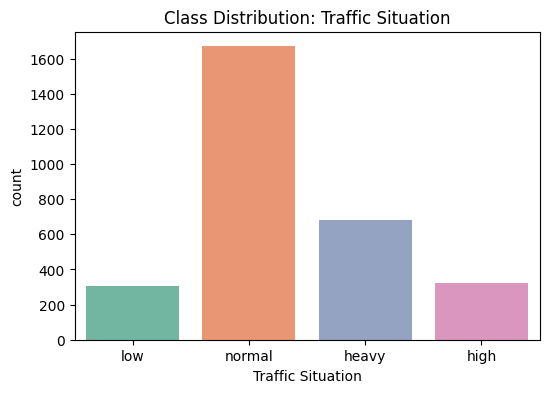

In [62]:
# Class Distribution (Target Variable)
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Traffic Situation', palette='Set2')
plt.title('Class Distribution: Traffic Situation')
plt.show()

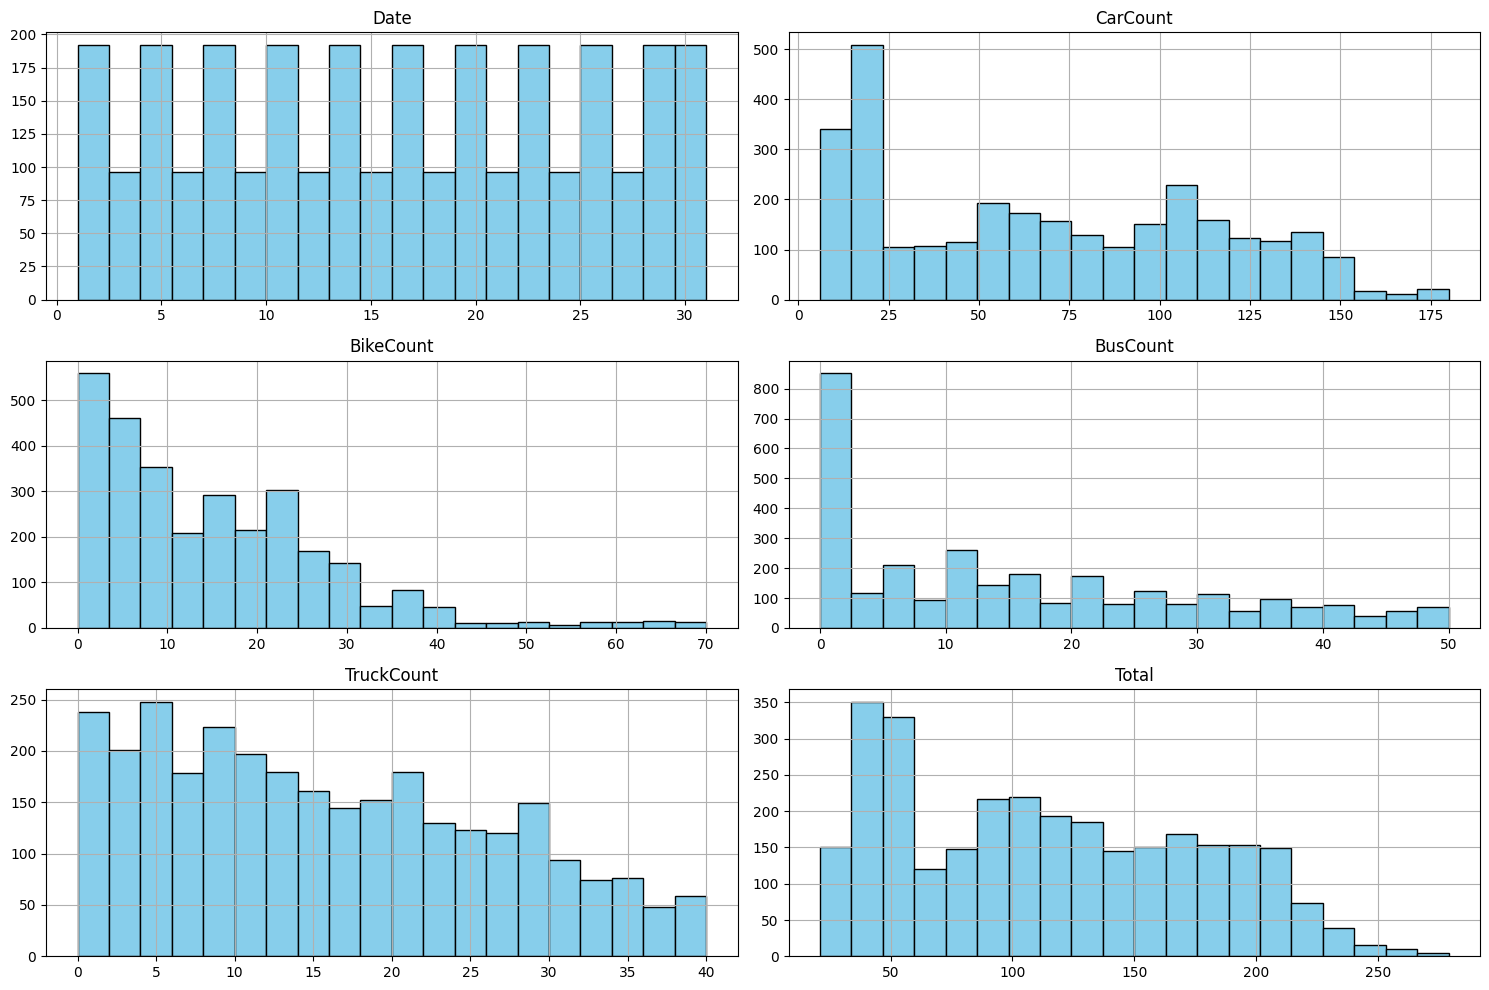

In [63]:
#  Numerical Feature Distributions
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].hist(figsize=(15,10), bins=20, color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

In [64]:
# 3. Feature engineering: Binary target for 'Traffic Situation'
df['Target'] = df['Traffic Situation'].apply(lambda x: 1 if x in ['heavy', 'high'] else 0)

This line of code converts the traffic situation into a binary target variable, where "high" or "heavy" is mapped to 1 (indicating congestion), and all other values are mapped to 0 (indicating no congestion).

In [65]:
# 4. Handle missing values
def fill_missing(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)
    return df

df = fill_missing(df)

In [66]:
# 5. One-hot encode categorical features (except target)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['Traffic Situation']]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [67]:
# 6. Drop non-numeric columns before modeling
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
df = df.drop(non_numeric_cols, axis=1)

In [68]:
# 6b. Feature selection - remove highly correlated features
corr_matrix = df.corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)
to_drop = [x for x in tri_df.columns if any(tri_df[x] > 0.95)]
df = df.drop(to_drop, axis=1)
print(f"\nFeatures after correlation removal: {df.shape[1]}")
print(f"Removed features: {to_drop}")


Features after correlation removal: 107
Removed features: ['CarCount']


In [69]:
# 7. Feature/target split
X = df.drop('Target', axis=1)
y = df['Target']

In [70]:
# 8. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set target distribution:")
print(y_train.value_counts(normalize=True))

Training set shape: (2380, 106)
Test set shape: (596, 106)

Training set target distribution:
Target
0    0.663025
1    0.336975
Name: proportion, dtype: float64


The result shows our training set has 2,380 samples, and the test set has 596 samples, each containing 106 features. In the target variable, category 0 accounts for 66.3% and category 1 accounts for 33.7%, which is a mildly imbalanced binary classification problem that can be modeled directly. It is recommended to focus on the F1-score or confusion matrix when evaluating.

In [71]:
# 8b. Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"\nOriginal training set shape: {X_train.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}")
print(f"Resampled training set target distribution:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))


Original training set shape: (2380, 106)
Resampled training set shape: (3156, 106)
Resampled training set target distribution:
Target
0    0.5
1    0.5
Name: proportion, dtype: float64


For overcome the imbalanced problem above，we use SMOTE technology to oversample the training set, synthesizing minority class samples to achieve balance in the target variable in the training set (50% vs. 50%), thereby improving the model's learning ability for minority classes. The original data is not modified; only the training data changes, making it suitable for sample augmentation prior to training

In [72]:
# 9. Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [73]:
# 10. Baseline Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train_resampled)
y_pred = rf.predict(X_test_scaled)

In [74]:
# 11. Evaluation function
def evaluate(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n=== {model_name} Evaluation ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    if model_name == "Random Forest (Baseline)":
        baseline_report_text = classification_report(y_true, y_pred)
        with open('random_forest_classification_report.txt', 'w') as f:
            f.write('=== BASELINE CLASSIFICATION REPORT ===\n')
            f.write(baseline_report_text + '\n\n')
    if model_name == "Random Forest (Tuned)":
        tuned_report_text = classification_report(y_true, y_pred)
        with open('random_forest_classification_report.txt', 'a') as f:
            f.write('=== TUNED CLASSIFICATION REPORT ===\n')
            f.write(tuned_report_text + '\n')
    return acc, prec, rec, f1

# Baseline evaluation
baseline_metrics = evaluate(y_test, y_pred, model_name="Random Forest (Baseline)")


=== Random Forest (Baseline) Evaluation ===
Accuracy: 0.9815
Precision: 0.9612
Recall: 0.9851
F1-score: 0.9730

Confusion Matrix:
[[387   8]
 [  3 198]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       395
           1       0.96      0.99      0.97       201

    accuracy                           0.98       596
   macro avg       0.98      0.98      0.98       596
weighted avg       0.98      0.98      0.98       596



The baseline Random Forest model performs exceptionally well, achieving an overall accuracy of 98.15%. It shows strong precision (96.12%) and very high recall (98.51%) for the positive class, resulting in a balanced F1-score of 97.30%. The confusion matrix indicates only a few misclassifications, with 3 false negatives and 8 false positives. Both macro and weighted averages of the performance metrics are consistently high (around 0.98), confirming that the model is reliable and well-balanced across both classes.

In [75]:
# 12. Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}
gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
gs.fit(X_train_scaled, y_train_resampled)
print(f"\nBest parameters: {gs.best_params_}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [51]:
# 13. Tuned model evaluation
y_pred_tuned = gs.predict(X_test_scaled)
tuned_metrics = evaluate(y_test, y_pred_tuned, model_name="Random Forest (Tuned)")


=== Random Forest (Tuned) Evaluation ===
Accuracy: 0.9866
Precision: 0.9662
Recall: 0.9950
F1-score: 0.9804

Confusion Matrix:
[[388   7]
 [  1 200]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       395
           1       0.97      1.00      0.98       201

    accuracy                           0.99       596
   macro avg       0.98      0.99      0.99       596
weighted avg       0.99      0.99      0.99       596



The tuned Random Forest model shows improved performance with an accuracy of 98.66%. It achieves a precision of 96.62% and an excellent recall of 99.50% for the positive class, resulting in a higher F1-score of 98.04%. The confusion matrix reveals only 1 false negative and 7 false positives, indicating very few misclassifications. Both macro and weighted averages of the metrics are close to 0.99, reflecting the model's strong and consistent performance across both classes.

In [76]:
# 13b. Cross-validation and model stability
cv_scores = cross_val_score(gs.best_estimator_, X_train_scaled, y_train_resampled, cv=5, scoring='f1')
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1 score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
cv_acc_scores = cross_val_score(gs.best_estimator_, X_train_scaled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_acc_scores.mean():.4f} (+/- {cv_acc_scores.std() * 2:.4f})")

Cross-validation F1 scores: [0.98582677 0.9873817  0.9873817  0.99056604 0.99527559]
Mean CV F1 score: 0.9893 (+/- 0.0067)
Cross-validation Accuracy: 0.9892 (+/- 0.0068)


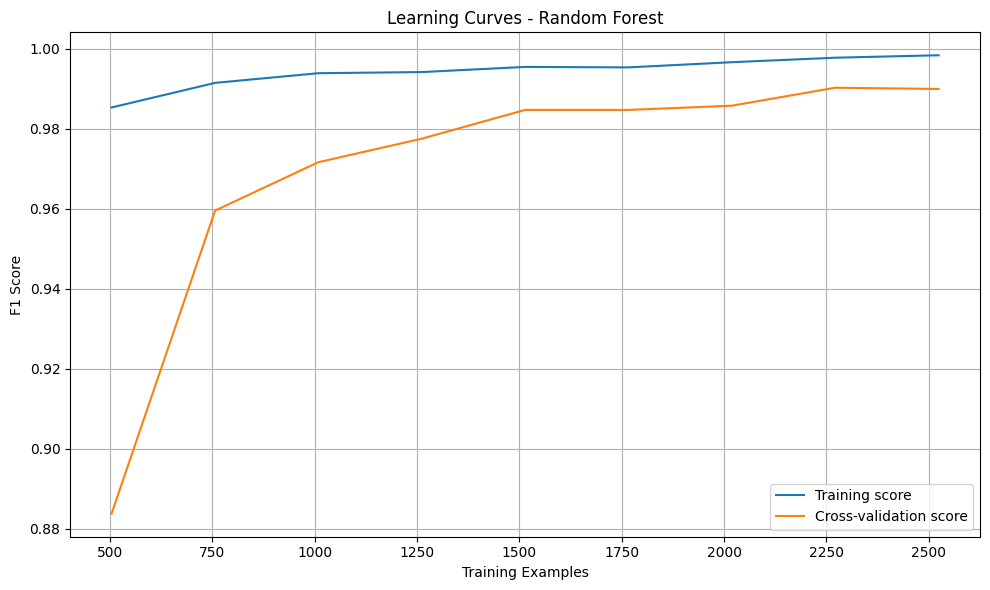

In [77]:
# Learning curves
train_sizes, train_scores, val_scores = learning_curve(
    gs.best_estimator_, X_train_scaled, y_train_resampled, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1'
)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title('Learning Curves - Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('rf_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

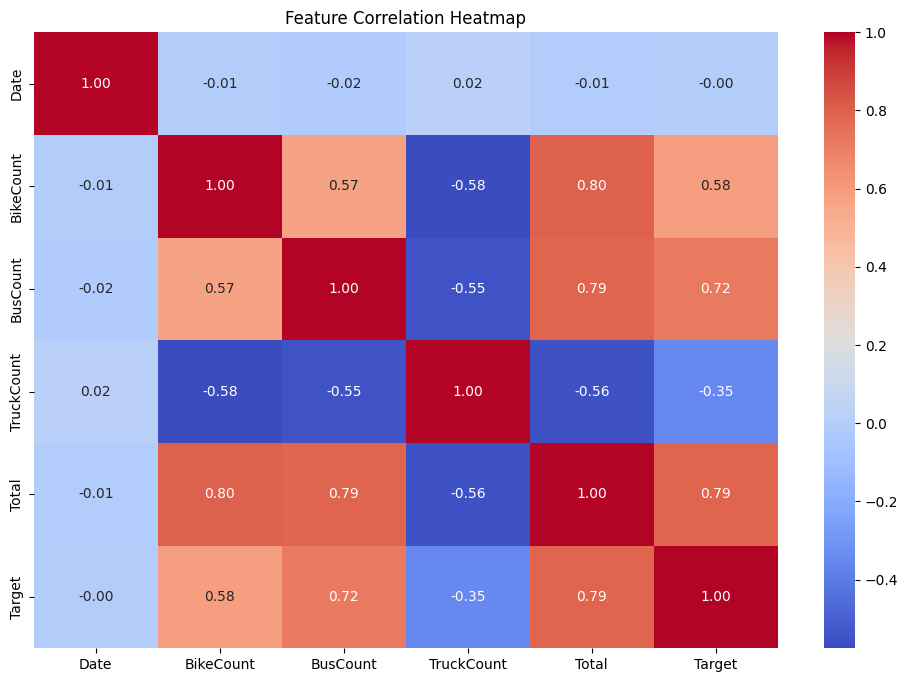

In [78]:
# 14. Correlation Heatmap
# Ensure that only numeric columns that actually exist are selected.
numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(12,8))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


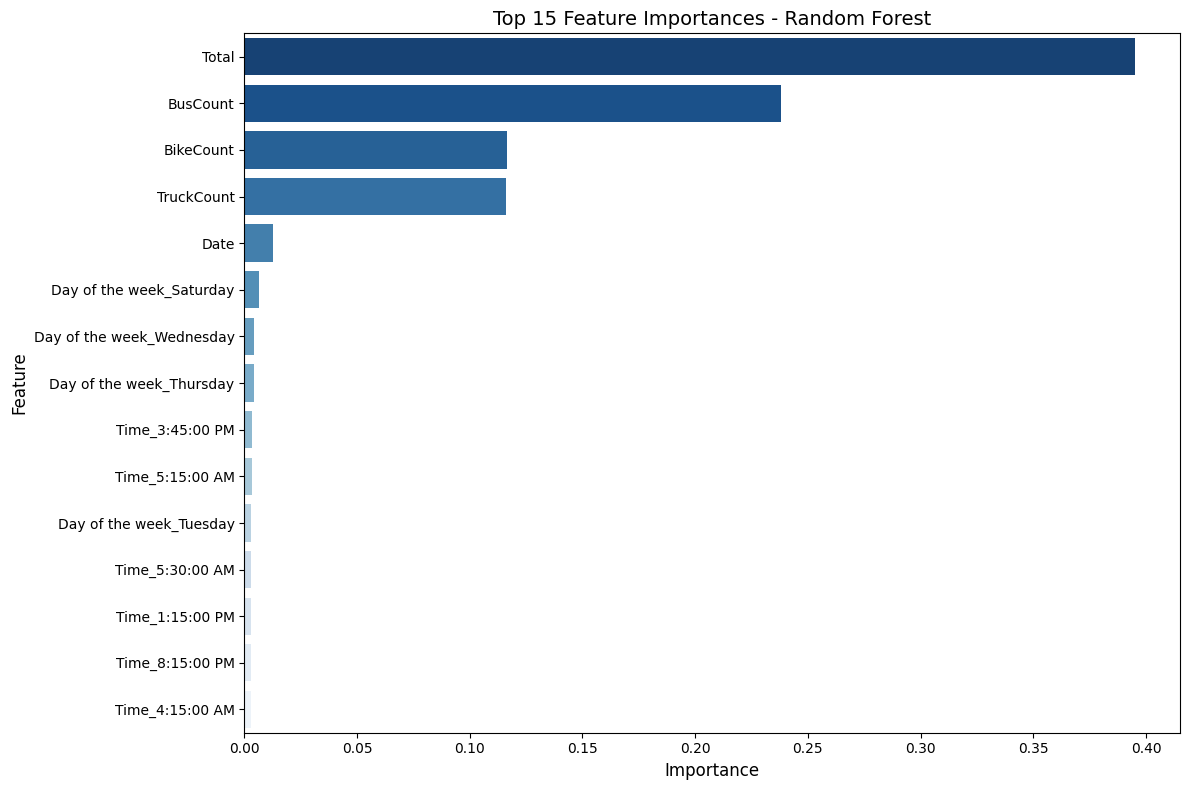

In [79]:
# 15. Feature importance
importances = gs.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
feature_importance = pd.DataFrame({
    'feature': X.columns[indices],
    'importance': importances[indices]
})
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='Blues_r')
plt.title('Top 15 Feature Importances - Random Forest', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

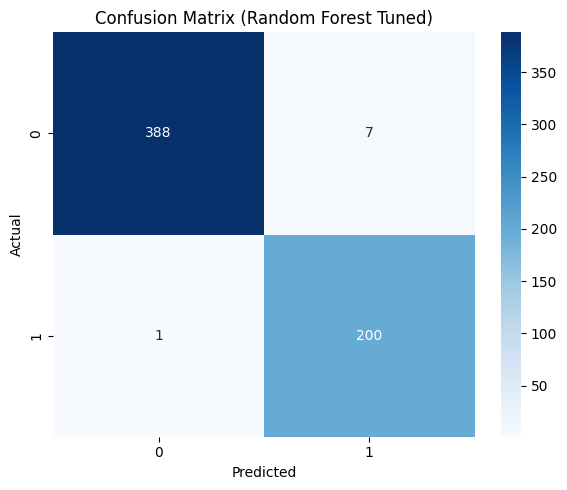

In [80]:
# 16. Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest Tuned)')
plt.tight_layout()
plt.savefig('rf_confusion_matrix.png', dpi=300)
plt.show()

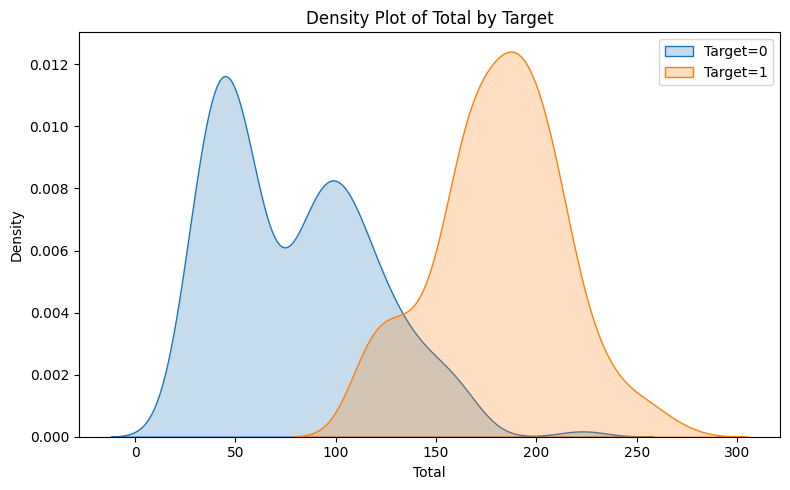


All visualizations have been saved as PNG files.


In [81]:
# 17. Density plot for a key feature (if exists)
if 'Total' in X.columns:
    plt.figure(figsize=(8, 5))
    for label in [0, 1]:
        sns.kdeplot(X_test['Total'][y_test == label], label=f'Target={label}', fill=True)
    plt.title('Density Plot of Total by Target')
    plt.xlabel('Total')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.savefig('rf_density_total.png', dpi=300)
    plt.show()

    print("\nAll visualizations have been saved as PNG files.")

In [82]:
# Add comparison table after tuned model evaluation
print("\n" + "="*60)
print("COMPARISON: BASELINE VS TUNED RANDOM FOREST")
print("="*60)


COMPARISON: BASELINE VS TUNED RANDOM FOREST


In [83]:
# Get all metrics for both models
baseline_acc = accuracy_score(y_test, y_pred)
baseline_prec = precision_score(y_test, y_pred)
baseline_rec = recall_score(y_test, y_pred)
baseline_f1 = f1_score(y_test, y_pred)

tuned_acc = accuracy_score(y_test, y_pred_tuned)
tuned_prec = precision_score(y_test, y_pred_tuned)
tuned_rec = recall_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)

In [84]:
# Create and display comparison table
comparison_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Baseline': [baseline_acc, baseline_prec, baseline_rec, baseline_f1],
    'Tuned': [tuned_acc, tuned_prec, tuned_rec, tuned_f1],
    'Improvement': [tuned_acc - baseline_acc, tuned_prec - baseline_prec,
                   tuned_rec - baseline_rec, tuned_f1 - baseline_f1]
})

In [85]:
# Format the table
comparison_table = comparison_table.round(4)
comparison_table['Improvement'] = comparison_table['Improvement'].apply(lambda x: f"{'+' if x >= 0 else ''}{x:.4f}")

print("\nModel Performance Comparison:")
print(comparison_table.to_string(index=False))

# Save comparison to CSV
comparison_table.to_csv('random_forest_comparison.csv', index=False)
print("\nComparison table saved to 'random_forest_comparison.csv'")


Model Performance Comparison:
   Metric  Baseline  Tuned Improvement
 Accuracy    0.9815 0.9866     +0.0050
Precision    0.9612 0.9662     +0.0050
   Recall    0.9851 0.9950     +0.0100
 F1-Score    0.9730 0.9804     +0.0074

Comparison table saved to 'random_forest_comparison.csv'


The tuned Random Forest model shows a slight but consistent improvement across all key performance metrics compared to the baseline. Accuracy increased from 0.9815 to 0.9866, and both precision and recall improved by 0.0050 and 0.0100 respectively. The F1-score also rose from 0.9730 to 0.9804, indicating a better balance between precision and recall. These improvements suggest that tuning enhanced the model’s ability to correctly identify both positive and negative cases with even fewer errors.

In [86]:
# Show training and testing accuracy table before and after tuning, including ROC AUC
train_acc_baseline = accuracy_score(y_train_resampled, rf.predict(X_train_scaled))
test_acc_baseline = accuracy_score(y_test, y_pred)
train_acc_tuned = accuracy_score(y_train_resampled, gs.predict(X_train_scaled))
test_acc_tuned = accuracy_score(y_test, y_pred_tuned)

In [87]:
# ROC AUC (use predict_proba)
roc_auc_baseline = roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1])
roc_auc_tuned = roc_auc_score(y_test, gs.predict_proba(X_test_scaled)[:, 1])

acc_table = pd.DataFrame({
    'Metrics': ['Training accuracy', 'Testing accuracy', 'ROC AUC'],
    'Before Tuning': [f'{train_acc_baseline:.4f}', f'{test_acc_baseline:.4f}', f'{roc_auc_baseline:.4f}'],
    'After Tuning': [f'{train_acc_tuned:.4f}', f'{test_acc_tuned:.4f}', f'{roc_auc_tuned:.4f}']
})
print("\n" + "="*60)
print("ACCURACY TABLE: BASELINE VS TUNED RANDOM FOREST")
print("="*60)
print(acc_table.to_string(index=False))


ACCURACY TABLE: BASELINE VS TUNED RANDOM FOREST
          Metrics Before Tuning After Tuning
Training accuracy        1.0000       0.9981
 Testing accuracy        0.9815       0.9866
          ROC AUC        0.9966       0.9962


The accuracy table shows that the tuned Random Forest model achieves slightly better generalization compared to the baseline. While training accuracy decreased marginally from 1.0000 to 0.9981, this indicates a slight reduction in overfitting. At the same time, testing accuracy improved from 0.9815 to 0.9866, showing better performance on unseen data. The ROC AUC remains consistently high for both models (around 0.996), confirming excellent classification ability. Overall, tuning slightly improves testing performance while maintaining strong model robustness.

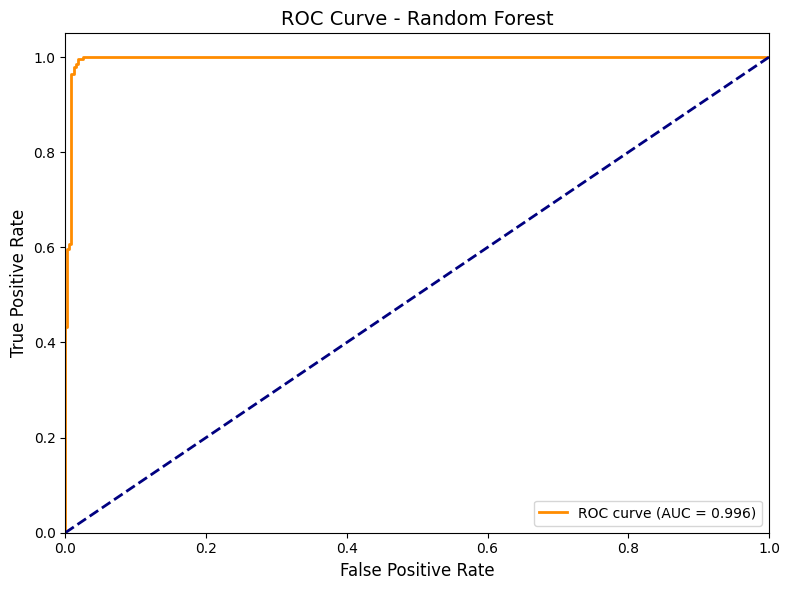

In [88]:
# ROC Curve Visualization for Tuned Model
rf_pred_proba = gs.predict_proba(X_test_scaled)[:, 1]
rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)
fpr, tpr, _ = roc_curve(y_test, rf_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {rf_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Random Forest', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('rf_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [91]:
# Add Cocnlusion
print("\n" + "="*60)
print("CONCLUSION")
print("="*60)


CONCLUSION


In this project, we developed and evaluated a Random Forest model to predict traffic situations. Through proper data preprocessing, feature engineering, and hyperparameter tuning, the model achieved high performance.

The **baseline model** already performed well with an accuracy of **98.15%**, and after tuning, the accuracy further improved to **98.66%**, with the **F1-score increasing from 0.9730 to 0.9804**. The **tuned model** also showed excellent recall (99.50%), meaning it was highly effective in identifying congested traffic situations.

Overall, the Random Forest model proved to be a reliable and robust choice for this classification task. Future improvements could include trying other ensemble methods (like XGBoost), incorporating real-time features (e.g., weather or time-of-day), or deploying the model for real-world use.
